<a href="https://colab.research.google.com/github/jettecampbell/data-science/blob/main/Jette_Campbell_Unit4ExerciesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm

# Unit 4 Exercises: Tinkering Hierarchical Models

These exercises are designed to force you to look at the nuances of the models we looked at in class, while exploring some "what ifs". There's also some mild data wrangling for you to enjoy at in task6.



**Task1**:

Redo the chemical shift hierarchical model, execpt with all Student T  and Half Student T likelihood and priors.

Then, compare group posteriors of the normal chem shift model with your new Student T model using a ridge plot.

In [ ]:
#load the data from my github page.
#cs stands for chemical shift data
url_cs = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/chemical_shifts_theo_exp.csv'
#I could have put the url string directly into pd.read_csv()
cs_data = pd.read_csv(url_cs)

In [ ]:
#element wise subtraction
diff_TminusE = cs_data.theo - cs_data.exp
#adds a column called 'diff_TminusE' as the fifth column of cs_data
cs_data.insert(loc=4,column='diff_TminusE',value=diff_TminusE)

In [ ]:
#identifies all the different amino acids in our data set
#and stores that information, plus original info, in the variable aa_encode
aa_encode = pd.Categorical(cs_data['aa'])
aa_encode

['ILE', 'TYR', 'SER', 'ALA', 'ARG', ..., 'LYS', 'ARG', 'LYS', 'GLU', 'SER']
Length: 1776
Categories (19, object): ['ALA', 'ARG', 'ASN', 'ASP', ..., 'THR', 'TRP', 'TYR', 'VAL']

In [ ]:
#Replaces all the amino acid names with a number in the variable aa_idx
aa_idx = aa_encode.codes
aa_idx

array([ 8, 17, 14, ..., 10,  5, 14], dtype=int8)

In [ ]:
#stores the category names in a dictionary
#this dictionary format is required
#for pymc to properly read the categories
aa_coords = {"aa": aa_encode.categories}
aa_coords

{'aa': Index(['ALA', 'ARG', 'ASN', 'ASP', 'GLN', 'GLU', 'GLY', 'HIS', 'ILE', 'LEU',
        'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL'],
       dtype='object')}

In [ ]:
with pm.Model(coords=aa_coords) as cs_Th_model:
    # hyperpriors. Notice how there's no dims argument.
    #this means that the hyperprior is shared across all amino acids
    μ_mu = pm.StudentT('μ_mu', nu = 10, mu = 0, sigma = 10)
    μ_sd = pm.HalfStudentT('μ_sd', nu = 10, sigma = 10)
    μ_nu = pm.Exponential('μ_nu', lam = 1/30)

    # priors. There is a different prior for each amino acid,
    #but now the μ priors 'talk' to one another through μ_mu and μ_sd
    N = pm.Exponential('N', lam = 1/30,
                      dims = "aa")

    μ = pm.StudentT('μ',
                  nu = μ_nu,
                  mu = μ_mu,
                  sigma = μ_sd,
                  dims = "aa")

    σ = pm.HalfStudentT('σ', nu = μ_mu, sigma = 10,
                      dims = "aa")

    #likelihood; same as before
    y = pm.StudentT('y',
                  nu = N[aa_idx],
                  mu = μ[aa_idx],
                  sigma = σ[aa_idx],
                  observed = cs_data.diff_TminusE)

    #cs for chemshift, h for heirarchical
    idata_cs_Th = pm.sample()

Output()

Output()

In [ ]:
with pm.Model(coords=aa_coords) as cs_Nh_model:
    # hyperpriors. Notice how there's no dims argument.
    #this means that the hyperprior is shared across all amino acids
    μ_mu = pm.Normal('μ_mu', mu = 0, sigma = 10)
    μ_sd = pm.HalfNormal('μ_sd', sigma = 10)

    # priors. There is a different prior for each amino acid,
    #but now the μ priors 'talk' to one another through μ_mu and μ_sd
    μ = pm.Normal('μ',
                  mu = μ_mu,
                  sigma = μ_sd,
                  dims = "aa")

    σ = pm.HalfNormal('σ', sigma = 10,
                      dims = "aa")

    #likelihood; same as before
    y = pm.Normal('y',
                  mu = μ[aa_idx],
                  sigma = σ[aa_idx],
                  observed = cs_data.diff_TminusE)

    #cs for chemshift, h for heirarchical
    idata_cs_Nh = pm.sample()

Output()

Output()

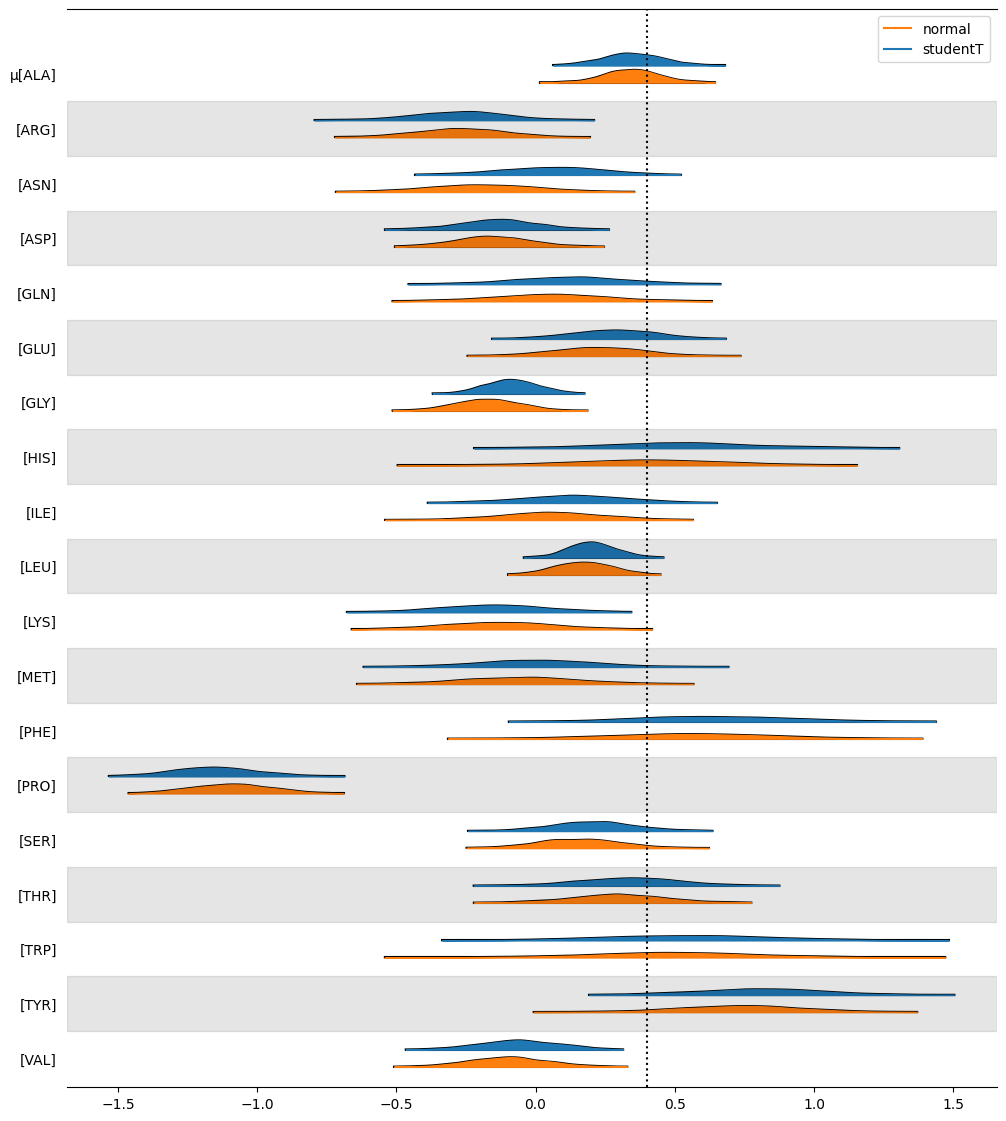

In [ ]:
axes = az.plot_forest([idata_cs_Th, idata_cs_Nh], kind="ridgeplot",
                      model_names=['studentT', 'normal'],
                      var_names='μ', combined=True, figsize=(12, 14),hdi_prob=0.997)

y_lims = axes[0].get_ylim()
axes[0].vlines(idata_cs_Th.posterior['μ_mu'].mean(), *y_lims, color="k", ls=":");

**Task2**:

Run a posterior predictive check for both models. Which seems to fit the data better?

Output()

(-10.0, 10.0)

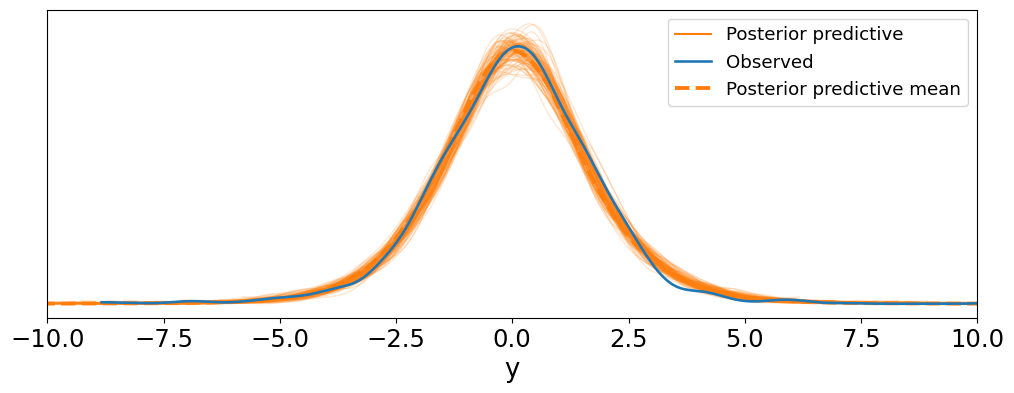

In [ ]:
pm.sample_posterior_predictive(idata_cs_Th, model=cs_Th_model, extend_inferencedata=True)
ax = az.plot_ppc(idata_cs_Th, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])
ax.set_xlim(-10,10)

Output()

<Axes: xlabel='y'>

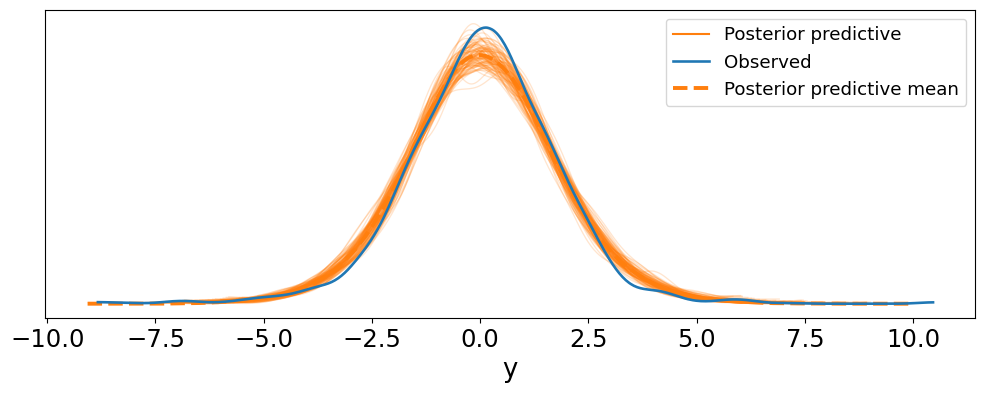

In [ ]:
pm.sample_posterior_predictive(idata_cs_Nh, model=cs_Nh_model, extend_inferencedata=True)
az.plot_ppc(idata_cs_Nh, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

The StudentT model seems to fit the chemshift data much better. The observed data and the posterior predictive mean are nearly identical

**Task3**:

Redo the soccer model, but this time, assume the groups are independent. This will be a non-hierarchical model.

In [ ]:
#load the data from my github page.
#sccr stands for soccer
url_sccr = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/football_players.csv'

#Turns the position column into a categorical variable
sccr_data = pd.read_csv(url_sccr,dtype={'position':'category'})

In [ ]:
#this is an array of the soccer positions,
#except they are given an int (number) label instead of a string (of letters)
pos_idx = sccr_data.position.cat.codes.values

#an array of the four strings that represent position
pos_codes = sccr_data.position.cat.categories

#puts coords in a dict, so pymc can read them
sccr_coords = {"pos": pos_codes}

In [ ]:
with pm.Model(coords = sccr_coords) as sccr_model:

    # Parameters for positions
    μ_p = pm.Beta('μ_p', alpha = 2, beta = 20, dims = "pos")

    ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")

    # Parameter for players
    θ = pm.Beta('θ', mu = μ_p[pos_idx], nu = ν_p[pos_idx])

    #This tells our model how many shots and goals each player has
    _ = pm.Binomial('gs',
                    n = sccr_data.shots.values, #shots for each player
                    p = θ, #guess of goals per shot
                    observed = sccr_data.goals.values) #goals per player

    #target_accept has a default of 0.8. Increasing it makes us less likely to
    #have divergences
    idata_sccr = pm.sample(target_accept = 0.98)

Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


**Task4**:

Run plot trace and rhat on your inference data object for the non-hierarchical soccer model. How does this compare to the hierarchical model?

<xarray.Dataset> Size: 43kB
Dimensions:  (θ_dim_0: 2682, pos: 4)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 21kB 0 1 2 3 4 5 ... 2676 2677 2678 2679 2680 2681
  * pos      (pos) <U2 32B 'DF' 'FW' 'GK' 'MF'
Data variables:
    θ        (θ_dim_0) float64 21kB 1.001 1.004 1.002 ... 1.004 0.9998 1.002
    μ_p      (pos) float64 32B 1.008 1.0 1.035 1.001
    ν_p      (pos) float64 32B 1.021 1.004 1.113 1.002

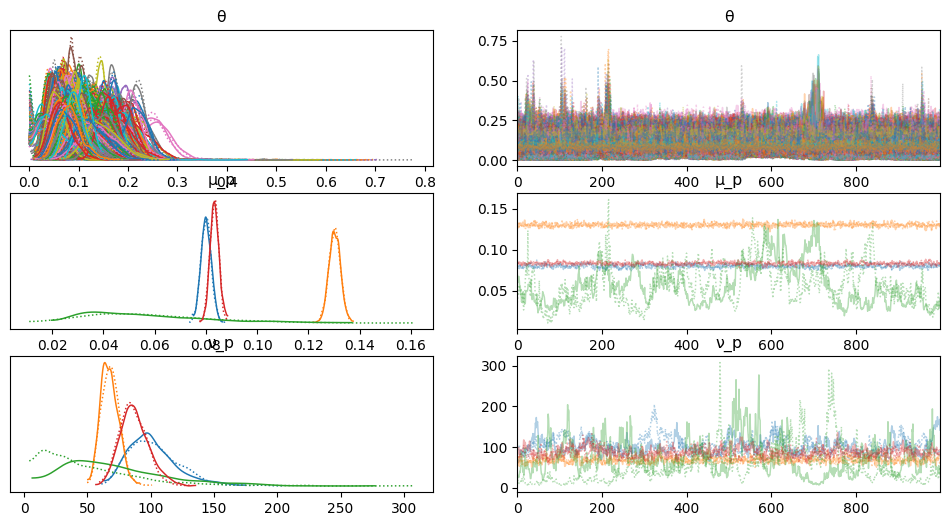

In [ ]:
az.plot_trace(idata_sccr)
az.rhat(idata_sccr)

This new non-hierarchal model compared to the hierarchal model has rhat values much closer to their ideal values (1 to 1.001). The GK values are a little high at about 1.09 which is concerning, but this is still better than the GK value from the original hierarhcal model at 1.242. In addition, the oberserved data compared to the plot predictions are pretty similar. The μ_p shows the solid lines and dotted lines very close together which means the predictions are more accurate. The same can be said for the ν_p, however, the green graph is very different.

**Task5**:

Plot the posterior of the means for each soccer position in the non-hierarchical model.

How do these posteriors compare to the hierarchical model we did in class?

array([<Axes: >], dtype=object)

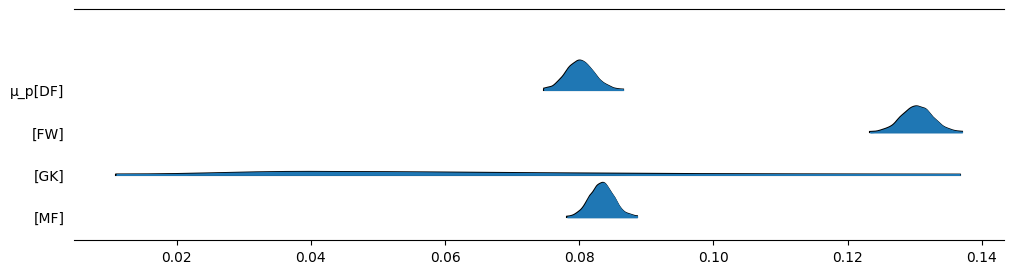

In [ ]:
az.plot_forest(idata_sccr, var_names=['μ_p'], combined=True, figsize=(12, 3), kind = 'ridgeplot', hdi_prob=0.998)

These posteriors look similar to the ones from the hierarchal model, however, they are a little smoother which shows that they are a little more accurate.

**Task6**:

Redo the soccer model as a hierarchical model, but remove all the goalkeepers (GK) from the data. In other words, run a hierarchical model on only the defenders, midfielders, and forwards.

In [ ]:
sccr_data_noGK = sccr_data[sccr_data.position != 'GK'].copy() #Copies old soccer data
sccr_data_noGK['position'] = pd.Categorical(sccr_data_noGK['position']) #Takes just the GK position
sccr_data_noGK['position'] = sccr_data_noGK['position'].cat.remove_unused_categories() #Removes GK from new list

In [ ]:
pos_idx_noGK = sccr_data_noGK.position.cat.codes.values #create position IDs for new list

pos_codes_noGK = sccr_data_noGK.position.cat.categories

sccr_coords_noGK = {"pos": pos_codes_noGK}

In [ ]:
with pm.Model(coords = sccr_coords_noGK) as sccr_model_noG:
    # Hyper parameters
    #
    μ = pm.Beta('μ', alpha = 2, beta = 20)
    ν = pm.Gamma('ν', mu = 55, sigma = 45)


    # Parameters for positions
    μ_p = pm.Beta('μ_p', mu = μ, nu = ν, dims = "pos")

    ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")

    # Parameter for players
    θ = pm.Beta('θ', mu = μ_p[pos_idx_noGK], nu = ν_p[pos_idx_noGK])

    #This tells our model how many shots and goals each player has
    _ = pm.Binomial('gs',
                    n = sccr_data_noGK.shots.values, #shots for each player
                    p = θ, #guess of goals per shot
                    observed = sccr_data_noGK.goals.values) #goals per player

    #target_accept has a default of 0.8. Increasing it makes us less likely to
    #have divergences
    idata_sccr_noGK = pm.sample(target_accept = 0.95)

Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


**Task7**:

Compare the plot trace and rhat results for the hierarchical model with GKs and without GKs. Then answer the following questions:
- Which model was easier for pymc to process?
- What do we lose by dropping Gks from the data set? What do we gain?

array([<Axes: >], dtype=object)

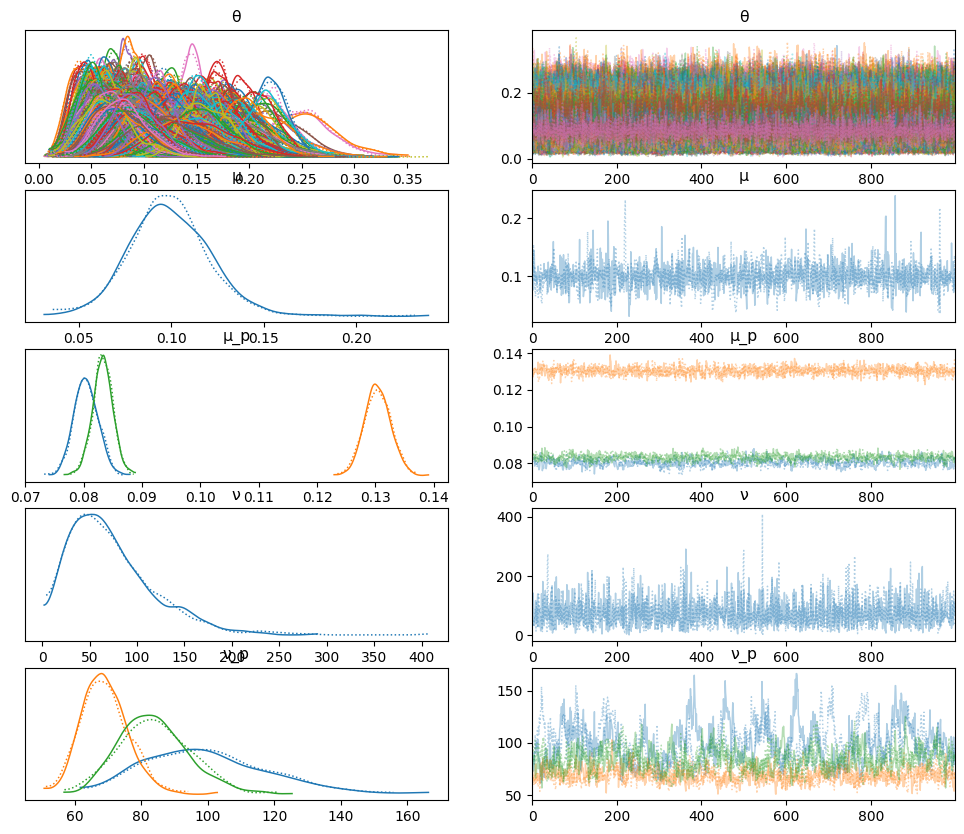

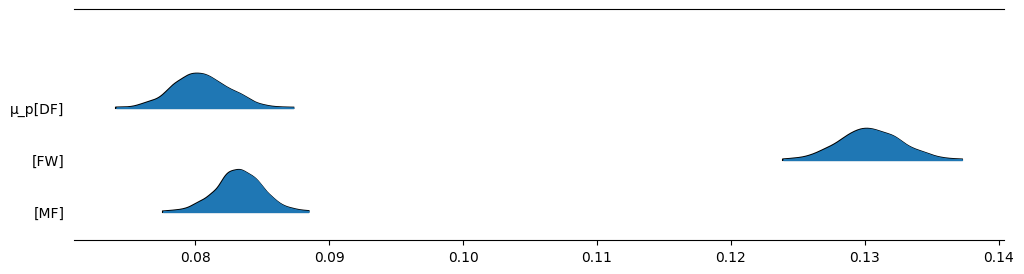

In [ ]:
az.plot_trace(idata_sccr_noGK)
az.rhat(idata_sccr_noGK)
az.plot_forest(idata_sccr_noGK, var_names=['μ_p'], combined=True, figsize=(12, 3), kind = 'ridgeplot', hdi_prob=0.998)

Without the GKs, the model is much more compact and neat, and also allows us to view the other positions easier. The model without the GKs was easier for pymc to process at about half the time because we have less data to go through. Dropping the GKs from the dataset loses the potential scoring data of each of the GKs, however, the GKs rarely score anyways and the data really just skews the entire model. This makes it harder to predict GK shot ratio, but easier for all the other positions. On the other hand, the model runs much faster, outputs much clearer data, and allows us to read the graphs easier. Overall I believe the model without GKs is the superior model for what we are trying to accomplish.